In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update path for Kaggle environment)
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing whitespace
df.columns = df.columns.str.strip()

# Ensure target column exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Stratified split: 80% train, 20% test
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["Humanitarian_Class"], random_state=42
)

# Save splits to CSV in current working directory
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# Structured summary table
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Humanitarian_Class"].value_counts(),
    "Test (20%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save summary table
split_summary.to_csv("/kaggle/working/split_summary.csv")

# Print result
print("✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.")


✅ Data split (80/20) completed and saved as CSV files in /kaggle/working.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
204/204 - 6s - 31ms/step - accuracy: 0.6355 - loss: 0.9182 - learning_rate: 0.0010
Epoch 2/20
204/204 - 1s - 3ms/step - accuracy: 0.8549 - loss: 0.3991 - learning_rate: 0.0010
Epoch 3/20
204/204 - 1s - 3ms/step - accuracy: 0.9120 - loss: 0.2442 - learning_rate: 0.0010
Epoch 4/20
204/204 - 1s - 3ms/step - accuracy: 0.9428 - loss: 0.1650 - learning_rate: 0.0010
Epoch 5/20
204/204 - 1s - 3ms/step - accuracy: 0.9598 - loss: 0.1174 - learning_rate: 0.0010
Epoch 6/20
204/204 - 1s - 3ms/step - accuracy: 0.9693 - loss: 0.0897 - learning_rate: 0.0010
Epoch 7/20
204/204 - 1s - 3ms/step - accuracy: 0.9740 - loss: 0.0785 - learning_rate: 0.0010
Epoch 8/20
204/204 - 1s - 3ms/step - accuracy: 0.9797 - loss: 0.0631 - learning_rate: 0.0010
Epoch 9/20
204/204 - 1s - 3ms/step - accuracy: 0.9809 - loss: 0.0574 - learning_rate: 0.0010
Epoch 10/20
204/204 - 1s - 3ms/step - accuracy: 0.9827 - loss: 0.0517 - learning_rate: 0.0010
Epoch 11/20
204/204 - 1s - 3ms/step - accuracy: 0.9868 - loss: 0.042

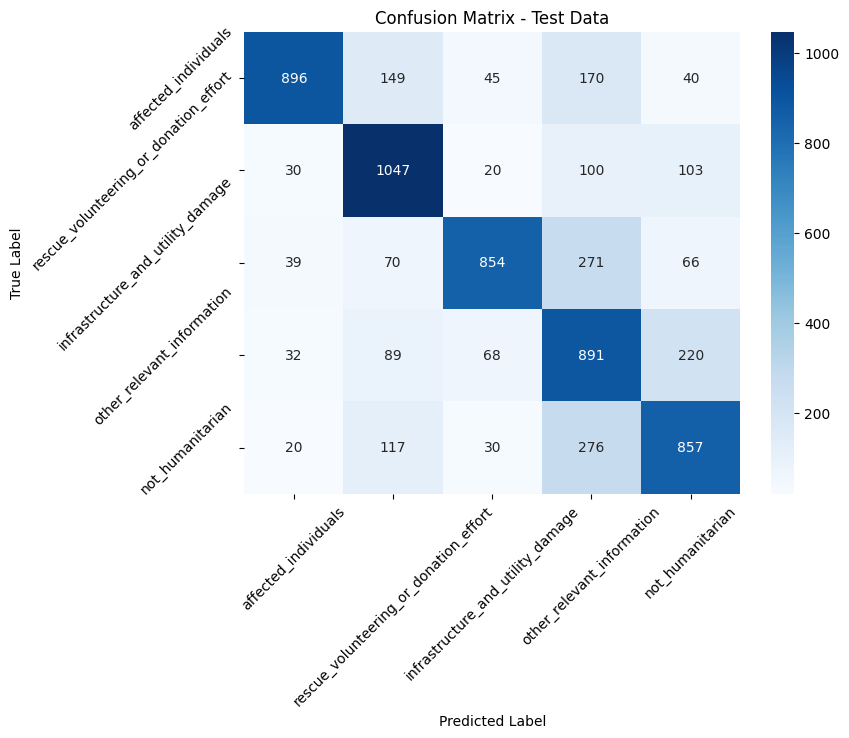

✅ Model saved as 'tfidf_humanitarian_cnn_model.h5'


In [12]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# Normalize column names
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# Label mapping
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# Preprocess labels
for df in [train_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# Fill missing text
for df in [train_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_text = vectorizer.fit_transform(train_df['processed_data'])
X_test_text = vectorizer.transform(test_df['processed_data'])

# Handcrafted features
for df in [train_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_num = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_train_combined = np.hstack((X_train_text.toarray(), X_train_num))
X_test_combined = np.hstack((X_test_text.toarray(), X_test_num))

# Apply SMOTE to training
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# Apply SMOTE to testing
max_class_test = max(Counter(y_test).values())
sampling_strategy_test = {label: max_class_test for label in np.unique(y_test)}
X_test_resampled, y_test_resampled = SMOTE(sampling_strategy=sampling_strategy_test, k_neighbors=3, random_state=42).fit_resample(X_test_combined, y_test)

# Model
def create_dense_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train
model = create_dense_model(X_train_resampled.shape[1], len(label_map))
callbacks = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)
]

model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=128, callbacks=callbacks, verbose=2)

# Evaluate on SMOTE-applied test set
test_loss, test_acc = model.evaluate(X_test_resampled, y_test_resampled, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred_test = model.predict(X_test_resampled)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Classification Report
report_test = classification_report(y_test_resampled, y_pred_test, target_names=label_map.keys())
print("\n📋 Classification Report (Test):\n", report_test)

# Confusion Matrix
cm_test = confusion_matrix(y_test_resampled, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Data")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Save model
model.save("tfidf_humanitarian_cnn_model.h5")
print("✅ Model saved as 'tfidf_humanitarian_cnn_model.h5'")
